In [140]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import median_absolute_error
import xgboost as xgb
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Background

This data is queried from the Clipper database sfofaretransaction table on the data lake. Different data sources across the agency will have different numbers.  This is two demonstrate that ridership can be predicted, but the counts may not match up with official accounts from crystal reports.  This data is for years avaliable in the lake database and for all operators combined.

	yesterday_swipes = The number of clipper rides on BART the pervious day
    
    year_ago_swipes = The number of clipper rides on BART on that day last year
    
    weekday_avg_month_prior =  The average daily weekday ridership for the pervious month
    
    weekdend_avg_month_prior =  The average daily weekend ridership for the pervious month

In [9]:
rides = pd.read_csv("all_ops_all_years_with_features.csv")
# there will be nan's for dates in 2013 where we don't have prior months data
rides_1418 = rides.dropna()

In [10]:
rides.sort_values('date').head(10)

,date,year,month,day,month_year,dow,year.1,weekend_flag,yesterday,year_ago,...,season,swipes,y_date,yesterday_swipes,ly_date,year_ago_swipes,mwd_month_year,weekday_avg_month_prior,mwe_month_year,weekend_avg_month_prior
1041,2013-01-21,2013,1,21,12013,1,2013,False,2013-01-20,2012-01-22,...,1,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
595,2013-01-22,2013,1,22,12013,2,2013,False,2013-01-21,2012-01-23,...,1,731,2013-01-21,200.0,NaN,NaN,NaN,NaN,NaN,NaN
527,2013-01-23,2013,1,23,12013,3,2013,False,2013-01-22,2012-01-24,...,1,600,2013-01-22,731.0,NaN,NaN,NaN,NaN,NaN,NaN
403,2013-01-24,2013,1,24,12013,4,2013,False,2013-01-23,2012-01-25,...,1,738,2013-01-23,600.0,NaN,NaN,NaN,NaN,NaN,NaN
1487,2013-01-25,2013,1,25,12013,5,2013,False,2013-01-24,2012-01-26,...,1,1580,2013-01-24,738.0,NaN,NaN,NaN,NaN,NaN,NaN
336,2013-01-26,2013,1,26,12013,6,2013,True,2013-01-25,2012-01-27,...,1,1341,2013-01-25,1580.0,NaN,NaN,NaN,NaN,NaN,NaN
845,2013-01-27,2013,1,27,12013,0,2013,True,2013-01-26,2012-01-28,...,1,1012,2013-01-26,1341.0,NaN,NaN,NaN,NaN,NaN,NaN
271,2013-01-28,2013,1,28,12013,1,2013,False,2013-01-27,2012-01-29,...,1,1230,2013-01-27,1012.0,NaN,NaN,NaN,NaN,NaN,NaN
90,2013-01-29,2013,1,29,12013,2,2013,False,2013-01-28,2012-01-30,...,1,1722,2013-01-28,1230.0,NaN,NaN,NaN,NaN,NaN,NaN
1548,2013-01-30,2013,1,30,12013,3,2013,False,2013-01-29,2012-01-31,...,1,2169,2013-01-29,1722.0,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
rides_1418.sort_values('date').head(10)

,date,year,month,day,month_year,dow,year.1,weekend_flag,yesterday,year_ago,...,season,swipes,y_date,yesterday_swipes,ly_date,year_ago_swipes,mwd_month_year,weekday_avg_month_prior,mwe_month_year,weekend_avg_month_prior
970,2014-01-21,2014,1,21,12014,2,2014,False,2014-01-20,2013-01-21,...,1,610287,2014-01-20,339254.0,2013-01-21,200.0,122013.0,584184.0,122013.0,358631.0
1342,2014-01-22,2014,1,22,12014,3,2014,False,2014-01-21,2013-01-22,...,1,750258,2014-01-21,610287.0,2013-01-22,731.0,122013.0,584184.0,122013.0,358631.0
2161,2014-01-23,2014,1,23,12014,4,2014,False,2014-01-22,2013-01-23,...,1,744432,2014-01-22,750258.0,2013-01-23,600.0,122013.0,584184.0,122013.0,358631.0
1187,2014-01-24,2014,1,24,12014,5,2014,False,2014-01-23,2013-01-24,...,1,731204,2014-01-23,744432.0,2013-01-24,738.0,122013.0,584184.0,122013.0,358631.0
1184,2014-01-25,2014,1,25,12014,6,2014,True,2014-01-24,2013-01-25,...,1,493683,2014-01-24,731204.0,2013-01-25,1580.0,122013.0,584184.0,122013.0,358631.0
1084,2014-01-26,2014,1,26,12014,0,2014,True,2014-01-25,2013-01-26,...,1,314091,2014-01-25,493683.0,2013-01-26,1341.0,122013.0,584184.0,122013.0,358631.0
969,2014-01-27,2014,1,27,12014,1,2014,False,2014-01-26,2013-01-27,...,1,553294,2014-01-26,314091.0,2013-01-27,1012.0,122013.0,584184.0,122013.0,358631.0
1000,2014-01-28,2014,1,28,12014,2,2014,False,2014-01-27,2013-01-28,...,1,741857,2014-01-27,553294.0,2013-01-28,1230.0,122013.0,584184.0,122013.0,358631.0
2166,2014-01-29,2014,1,29,12014,3,2014,False,2014-01-28,2013-01-29,...,1,754586,2014-01-28,741857.0,2013-01-29,1722.0,122013.0,584184.0,122013.0,358631.0
1193,2014-01-30,2014,1,30,12014,4,2014,False,2014-01-29,2013-01-30,...,1,737107,2014-01-29,754586.0,2013-01-30,2169.0,122013.0,584184.0,122013.0,358631.0


# XGBOOST Model with No Holidays and No Weather Data

In [12]:
rides_sorted = rides_1418.sort_values('date')
rides_sorted.head()

,date,year,month,day,month_year,dow,year.1,weekend_flag,yesterday,year_ago,...,season,swipes,y_date,yesterday_swipes,ly_date,year_ago_swipes,mwd_month_year,weekday_avg_month_prior,mwe_month_year,weekend_avg_month_prior
970,2014-01-21,2014,1,21,12014,2,2014,False,2014-01-20,2013-01-21,...,1,610287,2014-01-20,339254.0,2013-01-21,200.0,122013.0,584184.0,122013.0,358631.0
1342,2014-01-22,2014,1,22,12014,3,2014,False,2014-01-21,2013-01-22,...,1,750258,2014-01-21,610287.0,2013-01-22,731.0,122013.0,584184.0,122013.0,358631.0
2161,2014-01-23,2014,1,23,12014,4,2014,False,2014-01-22,2013-01-23,...,1,744432,2014-01-22,750258.0,2013-01-23,600.0,122013.0,584184.0,122013.0,358631.0
1187,2014-01-24,2014,1,24,12014,5,2014,False,2014-01-23,2013-01-24,...,1,731204,2014-01-23,744432.0,2013-01-24,738.0,122013.0,584184.0,122013.0,358631.0
1184,2014-01-25,2014,1,25,12014,6,2014,True,2014-01-24,2013-01-25,...,1,493683,2014-01-24,731204.0,2013-01-25,1580.0,122013.0,584184.0,122013.0,358631.0


In [143]:
split = int(.8*len(rides_sorted))

train_data = rides_sorted.iloc[0:split, :]
test_data = rides_sorted.iloc[split:, :]

features = ['month', 'day', 'dow', 'year', 'season', 'weekend_flag', 'yesterday_swipes', 'year_ago_swipes', 'weekday_avg_month_prior', 'weekend_avg_month_prior']

X = rides_sorted[features]
y = rides_sorted['swipes']
X_train = train_data[features]
X_test = test_data[features] 
y_train = train_data['swipes']
y_test = test_data['swipes']

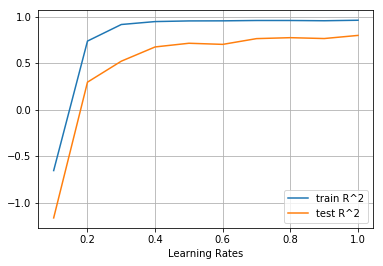

In [145]:
learning_rates = np.arange(0.1, 1.01, 0.1)
lr_train_r_2_scores_xgb = []
lr_test_r_2_scores_xgb = []

for rate in learning_rates:
    xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = rate,
                max_depth = 5, alpha = 10, n_estimators = 10)
    xg_reg.fit(X_train,y_train)
    preds = xg_reg.predict(X_train)
    y_hat = xg_reg.predict(X_test)
    lr_train_r_2_scores_xgb.append(r2_score(y_train, preds))
    lr_test_r_2_scores_xgb.append(r2_score(y_test, y_hat))
    
fig, ax = plt.subplots()
ax.plot(learning_rates, lr_train_r_2_scores_xgb, label='train R^2')
ax.plot(learning_rates, lr_test_r_2_scores_xgb, label='test R^2')
ax.set_xlabel("Learning Rates")
ax.legend()
ax.grid()
plt.show()

In [146]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 1.0,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_train)
y_hat = xg_reg.predict(X_test)

train_r_2_score_xgb = r2_score(y_train, preds)

test_r_2_score_xgb = r2_score(y_test, y_hat)

print(train_r_2_score_xgb)
print(test_r_2_score_xgb)

0.9614273492097967
0.7983198049647163


In [147]:
abs_errors_percent = abs((y_hat - y_test)/y_test)
print("This model's predictions is on average about +/- ", round(np.mean(abs_errors_percent), 4), "off of the actual ridership for that day")

This model's predictions is on average about +/-  0.1129 off of the actual ridership for that day


In [32]:
abs_errors = abs(y_hat - y_test)
sq_errors = (y_hat - y_test)**2
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs_errors), 4))
print('RMSE :', round(np.sqrt(np.mean(sq_errors)), 4))

Mean Absolute Error: 62570.6741
RMSE : 99289.9245


In [34]:
from sklearn.metrics import median_absolute_error
median_absolute_error(y_test, y_hat)

37898.8125

In [35]:
from sklearn.model_selection import cross_val_score

scores_dtr = cross_val_score(xg_reg, X, y, cv=10,scoring='explained_variance') # 10-fold cross validation
print('scores for k=10 fold validation:',scores_dtr)
print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_dtr.mean(), scores_dtr.std() * 2))

scores for k=10 fold validation: [0.64959925 0.75599298 0.8983886  0.82242641 0.92010046 0.89789633
 0.91270733 0.86346322 0.90817614 0.81070038]
Est. explained variance: 0.84 (+/- 0.16)


In [38]:
from sklearn.metrics import explained_variance_score
# Best possible score is 1.0, lower values are worse.
explained_variance_score(y_test, y_hat)

0.8070746691768629

In [39]:
# train data
explained_variance_score(y_train, preds)

0.9614282119882158

In [41]:
for i, j in zip(features, xg_reg.feature_importances_):
    print(i, " - ", j)

month  -  0.004860439
day  -  0.018375413
dow  -  0.011133514
year  -  0.0015581527
season  -  0.0036907082
weekend_flag  -  0.8719533
yesterday_swipes  -  0.0056906706
year_ago_swipes  -  0.06780629
weekday_avg_month_prior  -  0.014124221
weekend_avg_month_prior  -  0.00080713263


In [44]:
errors_percent = (y_hat - y_test)/y_test
test_errors = X_test
test_errors['actual'] = y_test
test_errors['predicted'] = y_hat
test_errors['errors_percents'] = errors_percent
test_errors.sort_values('errors_percents')[['month', 'day', 'year', 'errors_percents', 'actual', 'predicted']]


,month,day,year,errors_percents,actual,predicted
891,6,24,2018,-0.776580,391022,87362.250000
827,12,24,2018,-0.666578,299764,99947.820312
1477,11,24,2018,-0.654045,303763,105088.187500
517,6,23,2018,-0.570769,507497,217833.234375
898,5,26,2018,-0.490529,439531,223928.218750
704,10,27,2018,-0.468447,500364,265970.187500
205,5,27,2018,-0.418779,309030,179614.859375
1544,9,30,2018,-0.414934,359064,210076.062500
84,11,25,2018,-0.397239,287330,173191.218750
512,5,24,2018,-0.391293,858465,522553.562500


Text(0.5, 1.0, 'Test Set Error Percentage')

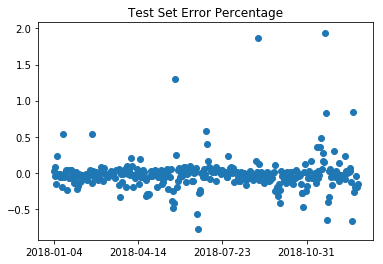

In [63]:
# Christmas is the most poorly perdicted
from matplotlib.pyplot import scatter, title


fig, ax = plt.pyplot.subplots()
scatter(test_data['date'], errors_percent)
ax.set_xticks(ax.get_xticks()[::100])
title("Test Set Error Percentage")

# Add Holiday Flags and Weather Data

In [46]:
# downloaded from https://gist.github.com/shivaas/4758439
holidays = pd.read_csv("bank_holidays.csv", header=None)
holidays.head()

,0,1,2
0,1,2012-01-02,New Year Day
1,2,2012-01-16,Martin Luther King Jr. Day
2,3,2012-02-20,Presidents Day (Washingtons Birthday)
3,4,2012-05-28,Memorial Day
4,5,2012-07-04,Independence Day


In [47]:
def is_holiday(row):
    # include Christmas Eve and Ney Year's Eve
    if (row['date'] in list(holidays[1])) or (row['day']==24 and row['month']==12) or (row['day']==31 and row['month']==12):
        return 1.0
    else:
        return 0.0
    
rides_sorted['Holiday'] = rides_sorted.apply(is_holiday, axis=1)

In [48]:
rides_holidays = rides_sorted
for holiday in list(holidays[2].unique()):
    holiday_df = holidays[holidays[2]==holiday]
    def is_holiday(row):
        if (row['date'] in list(holiday_df[1])):
            return 1.0
        else:
            return 0.0
    rides_holidays[holiday] = rides_holidays.apply(is_holiday, axis=1)


In [49]:
def is_xmas_eve(row):
    # include Christmas Eve and Ney Year's Eve
    if row['day']==24 and row['month']==12:
        return 1.0
    else:
        return 0.0
    
rides_holidays['Christmas Eve'] = rides_holidays.apply(is_xmas_eve, axis=1)

In [50]:
def is_ny_eve(row):
    # include Christmas Eve and Ney Year's Eve
    if row['day']==31 and row['month']==12:
        return 1.0
    else:
        return 0.0
    
rides_holidays['New Years Eve'] = rides_holidays.apply(is_ny_eve, axis=1)

In [51]:
rides_holidays[rides_holidays.month==12].sort_values('date', ascending=False).iloc[0:10, :]

,date,year,month,day,month_year,dow,year.1,weekend_flag,yesterday,year_ago,...,Presidents Day (Washingtons Birthday),Memorial Day,Independence Day,Labor Day,Columbus Day,Veterans Day,Thanksgiving Day,Christmas Day,Christmas Eve,New Years Eve
1534,2018-12-31,2018,12,31,122018,1,2018,False,2018-12-30,2017-12-31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1635,2018-12-30,2018,12,30,122018,0,2018,True,2018-12-29,2017-12-30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
903,2018-12-29,2018,12,29,122018,6,2018,True,2018-12-28,2017-12-29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,2018-12-28,2018,12,28,122018,5,2018,False,2018-12-27,2017-12-28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
834,2018-12-27,2018,12,27,122018,4,2018,False,2018-12-26,2017-12-27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
712,2018-12-26,2018,12,26,122018,3,2018,False,2018-12-25,2017-12-26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,2018-12-25,2018,12,25,122018,2,2018,False,2018-12-24,2017-12-25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
827,2018-12-24,2018,12,24,122018,1,2018,False,2018-12-23,2017-12-24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
85,2018-12-23,2018,12,23,122018,0,2018,True,2018-12-22,2017-12-23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,2018-12-22,2018,12,22,122018,6,2018,True,2018-12-21,2017-12-22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Weather Data is from https://www.ncdc.noaa.gov/cdo-web/datasets#GHCND.  It must be requested for download. 

In [54]:
weather = pd.read_csv("1709387.csv")
weather.columns = ['station', 'name', 'date', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN'] 
weather.head()

,station,name,date,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",2013-01-01,0.00,NaN,NaN,NaN,53,43
1,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",2013-01-02,0.00,0.0,0.0,NaN,56,42
2,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",2013-01-03,0.00,0.0,0.0,NaN,54,41
3,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",2013-01-04,0.00,0.0,0.0,NaN,57,45
4,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",2013-01-05,0.25,0.0,0.0,NaN,53,45


In [55]:
rides_weather = pd.merge(rides_holidays, weather[['date', 'PRCP', 'TMAX', 'TMIN']], on='date', how='left')

In [56]:
rides_weather.head()

,date,year,month,day,month_year,dow,year.1,weekend_flag,yesterday,year_ago,...,Labor Day,Columbus Day,Veterans Day,Thanksgiving Day,Christmas Day,Christmas Eve,New Years Eve,PRCP,TMAX,TMIN
0,2014-01-21,2014,1,21,12014,2,2014,False,2014-01-20,2013-01-21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,49.0
1,2014-01-22,2014,1,22,12014,3,2014,False,2014-01-21,2013-01-22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,48.0
2,2014-01-23,2014,1,23,12014,4,2014,False,2014-01-22,2013-01-23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,48.0
3,2014-01-24,2014,1,24,12014,5,2014,False,2014-01-23,2013-01-24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,49.0
4,2014-01-25,2014,1,25,12014,6,2014,True,2014-01-24,2013-01-25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,50.0


In [57]:
rides_weather[rides_weather.PRCP.isna()]  # missing weather data for one date

,date,year,month,day,month_year,dow,year.1,weekend_flag,yesterday,year_ago,...,Labor Day,Columbus Day,Veterans Day,Thanksgiving Day,Christmas Day,Christmas Eve,New Years Eve,PRCP,TMAX,TMIN
1499,2018-02-28,2018,2,28,22018,3,2018,False,2018-02-27,2017-02-28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [58]:
rides_weather = rides_weather.fillna(0.0) # fill date with 0.0 

In [78]:
split = int(.8*len(rides_holidays))

train_data = rides_weather.iloc[0:split, :]
test_data = rides_weather.iloc[split:, :]

features = ['month', 'day', 'dow', 'year', 'season', 'weekend_flag', 
            'yesterday_swipes', 'year_ago_swipes', 'weekday_avg_month_prior', 
            'weekend_avg_month_prior', 'Holiday', 'New Year Day',
           'Martin Luther King Jr. Day', 'Presidents Day (Washingtons Birthday)',
           'Memorial Day', 'Independence Day', 'Labor Day', 'Columbus Day',
           'Veterans Day', 'Thanksgiving Day', 'Christmas Day', 'Christmas Eve',
           'New Years Eve', 'PRCP', 'TMAX', 'TMIN']

X = rides_weather[features]
y = rides_weather['swipes']

X_train = train_data[features]
X_test = test_data[features] 
y_train = train_data['swipes']
y_test = test_data['swipes']


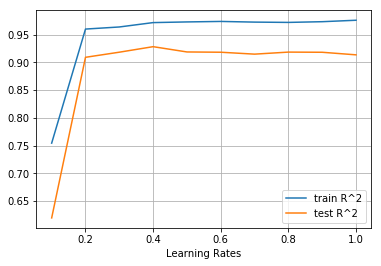

In [111]:
learning_rates = np.arange(0.1, 1.01, 0.1)
lr_train_r_2_scores_xgb = []
lr_test_r_2_scores_xgb = []

for rate in learning_rates:
    xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.5, learning_rate = rate,
                max_depth = 3, alpha = 10, n_estimators = 20)
    xg_reg.fit(X_train,y_train)
    preds = xg_reg.predict(X_train)
    y_hat = xg_reg.predict(X_test)
    lr_train_r_2_scores_xgb.append(r2_score(y_train, preds))
    lr_test_r_2_scores_xgb.append(r2_score(y_test, y_hat))
    
fig, ax = plt.subplots()
ax.plot(learning_rates, lr_train_r_2_scores_xgb, label='train R^2')
ax.plot(learning_rates, lr_test_r_2_scores_xgb, label='test R^2')
ax.set_xlabel("Learning Rates")
ax.legend()
ax.grid()
plt.show()

In [128]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.5, learning_rate = 0.33,
                max_depth = 3, alpha = 10, n_estimators = 20)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_train)
y_hat = xg_reg.predict(X_test)

train_r_2_score_xgb = r2_score(y_train, preds)

test_r_2_score_xgb = r2_score(y_test, y_hat)

print(train_r_2_score_xgb)
print(test_r_2_score_xgb)

0.9683015755678559
0.9305875134175443


In [129]:
abs_errors_percent = abs((y_hat - y_test)/y_test)
print("This model's predictions is on average about +/- ", round(np.mean(abs_errors_percent), 4), "off of the actual ridership for that day")

This model's predictions is on average about +/-  0.0663 off of the actual ridership for that day


In [130]:
abs_errors = abs(y_hat - y_test)
sq_errors = (y_hat - y_test)**2
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs_errors), 4))
print('RMSE :', round(np.sqrt(np.mean(sq_errors)), 4))

Mean Absolute Error: 42025.2631
RMSE : 58249.5206


In [131]:
from sklearn.metrics import median_absolute_error
median_absolute_error(y_test, y_hat)

28594.734375

In [132]:
from sklearn.model_selection import cross_val_score

scores_dtr = cross_val_score(xg_reg, X, y, cv=10,scoring='explained_variance') # 10-fold cross validation
print('scores for k=10 fold validation:',scores_dtr)
print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_dtr.mean(), scores_dtr.std() * 2))

scores for k=10 fold validation: [0.78924476 0.88577763 0.97671159 0.95207101 0.97179978 0.95013359
 0.9694054  0.962247   0.97099724 0.93227521]
Est. explained variance: 0.94 (+/- 0.11)


In [133]:
from sklearn.metrics import explained_variance_score
# Best possible score is 1.0, lower values are worse.
explained_variance_score(y_test, y_hat)

0.9409565603015563

In [134]:
# train data
explained_variance_score(y_train, preds)

0.9683021980659163

In [135]:
for i, j in zip(features, xg_reg.feature_importances_):
    print(i, " - ", j)

month  -  0.04268207
day  -  0.0021688235
dow  -  0.19253153
year  -  0.0029041667
season  -  0.004221385
weekend_flag  -  0.236351
yesterday_swipes  -  0.09620029
year_ago_swipes  -  0.17268443
weekday_avg_month_prior  -  0.0057145325
weekend_avg_month_prior  -  0.0028937892
Holiday  -  0.102595784
New Year Day  -  0.0
Martin Luther King Jr. Day  -  0.0
Presidents Day (Washingtons Birthday)  -  0.0
Memorial Day  -  0.0
Independence Day  -  0.010184227
Labor Day  -  0.0028700256
Columbus Day  -  0.0
Veterans Day  -  0.0
Thanksgiving Day  -  0.03128185
Christmas Day  -  0.07077076
Christmas Eve  -  0.0
New Years Eve  -  0.0
PRCP  -  0.0041584587
TMAX  -  0.019511692
TMIN  -  0.00027520733


In [136]:
errors_percent = (y_hat - y_test)/y_test
test_errors = X_test
test_errors['actual'] = y_test
test_errors['predicted'] = y_hat
test_errors['errors_percents'] = errors_percent
test_errors.sort_values('errors_percents')[['month', 'day', 'year', 'errors_percents', 'actual', 'predicted']]


,month,day,year,errors_percents,actual,predicted
1449,1,9,2018,-0.248868,755471,567458.12500
1721,10,8,2018,-0.211416,664139,523729.43750
1624,7,3,2018,-0.208623,807322,638895.87500
1777,12,3,2018,-0.208168,676537,535703.43750
1803,12,29,2018,-0.205047,369803,293975.90625
1756,11,12,2018,-0.181151,506591,414821.78125
1694,9,11,2018,-0.178826,946226,777016.25000
1708,9,25,2018,-0.177775,945016,777016.25000
1802,12,28,2018,-0.176670,523107,430689.59375
1688,9,5,2018,-0.173294,939894,777016.25000


Text(0.5, 1.0, 'Test Set Error Percentage')

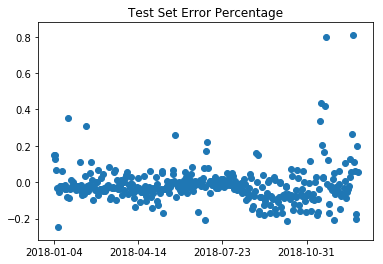

In [141]:
# Christmas and days nearby holidays are the most poorly perdicted
from matplotlib.pyplot import scatter, title


fig, ax = plt.subplots()
scatter(test_data['date'], errors_percent)
ax.set_xticks(ax.get_xticks()[::100])
title("Test Set Error Percentage")